# Who Owns Burlington?
#### Analysis and Dashboarding for Burlington, VT Real Estate

# Table of Contents

* Abstract
* Obtain and Scrub
* Explore
* Dashboard
* Report
* Conclusions


# Abstract
The city of Burlington, VT provides useful open data on property ownership through its online portal. However, because it is a common practice for an LLC or other business entity to be listed as the owner of a property, it can be difficult to figure out exactly how many properties are owned by an individual or group.

To address this, I performed an analysis of last names associated with properties in Burlington, VT, combining matches from directly listed property owners and principals of companies listed as owners. I geocoded the results and tagged each property with its associated city ward, enabling statistical and geospatial analysis through a custom-built dashboard and other statistical software.

The resulting analysis revealed that there are in fact a small group of particularly dominant families and real estate agencies/moguls that own a disproportionate amount of property in Burlington, VT. Some have registered these properties in a straightforward way, while others have registered them under many different LLCs or other types of organizations.

I additionally found that some ownership groups tend to focus their efforts on particular geographic clusters, mass purchasing property and land in a single area. A closer look at this data could reveal future development plans in the city of Burlington.

# Obtain and Scrub

Scrubbing the data was an extensive standalone process, detailed in `Cleaning.ipynb`

# Explore

In [1]:
import pandas as pd
import numpy as np
import plotly
import plotly.graph_objs as go
import re

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from scipy.stats import iqr

init_notebook_mode(connected=True)

In [2]:
properties = pd.read_csv('../data/csvs/geocoded_properties.csv')
principals = pd.read_csv('../data/csvs/props_to_principals.csv')

In [3]:
properties = properties.iloc[:, 3:]

In [4]:
properties['Listed Real Value'].describe()

count    1.083100e+04
mean     4.955365e+05
std      4.001529e+06
min      3.000000e+02
25%      1.932000e+05
50%      2.425000e+05
75%      3.561500e+05
max      3.873314e+08
Name: Listed Real Value, dtype: float64

We can see that there are some enormous outliers in this distribution. This is going to make visualizing these difficult. We'll separate them from the rest of the data and list them so we know what they are. Then, we'll look at the more representative portion of the Burlington housing market.

In [5]:
def split_outliers(array):
    """Splits lower and upper outliers from an array.
    
    Args:
        array: Array of ints or floats.
        
    Returns:
        lower_outliers (array)
        central_values (array)
        upper_outliers (array)
    
    """
    array_iqr = iqr(array)
    Q1 = array.describe()['25%']
    Q3 = array.describe()['75%']
    bound = array_iqr * 1.5
    
    lower_bound = max([Q1 - bound, 0])
    upper_bound = Q3 + bound
    
    print("Central Values lie between {} and {}".format(lower_bound, upper_bound))
    
    lower_outliers = array[array < (lower_bound)]
    central_values = array[(array >= (lower_bound)) & (array <= (upper_bound))]
    upper_outliers = array[array > (upper_bound)]
    
    print(
    """
    # Central Values: {}
    # Lower Outliers: {}
    # Upper Outliers: {}
    """.format(len(central_values), len(lower_outliers), len(upper_outliers)))
    
    return lower_outliers, central_values, upper_outliers

In [6]:
lower, central, upper = split_outliers(properties['Listed Real Value'])

Central Values lie between 0 and 600575.0

    # Central Values: 9812
    # Lower Outliers: 0
    # Upper Outliers: 1019
    


In [57]:
def plotly_hist(array, x_label=None, y_label=None, ymax=None):
    """Creates a histogram.
    
    Args:
        array: Numerical values.
        x_label (str)
        y_label (str)
    
    """
    trace = go.Histogram(x=array)
    data = [trace]
    layout = go.Layout(
        title="Burlington Property Value Distribution",
        xaxis=dict(
            title=x_label
        ),
        yaxis=dict(
            title=y_label
        ),
        shapes=[dict(
            type='line',
            x0=array.median(),
            y0=0,
            x1=array.median(),
            y1=ymax,
            line=dict(
                color='red'
            )
        )]
    )
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, filename='histogram')

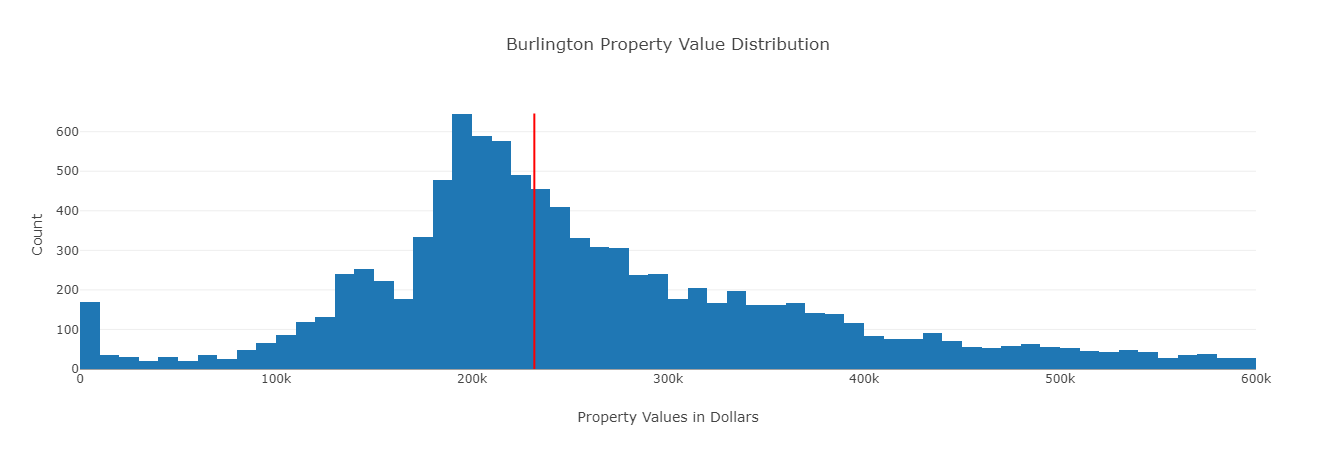

In [58]:
plotly_hist(central, "Property Values in Dollars", "Count", 646)

We can make a few observations from the distribution of these central values:

* There is an uptick on the lower end of the distribution. Looking closer, I found that these are **mobile homes without land**
* The distribution is right skewed, and the majority of properties are valued between **\$190K** and **\$360K**

In [9]:
central_geo = properties[(properties["Listed Real Value"] <= max(central)) & (properties["Listed Real Value"] >= min(central))]

In [10]:
ward_list = list(central_geo.columns[-8:])

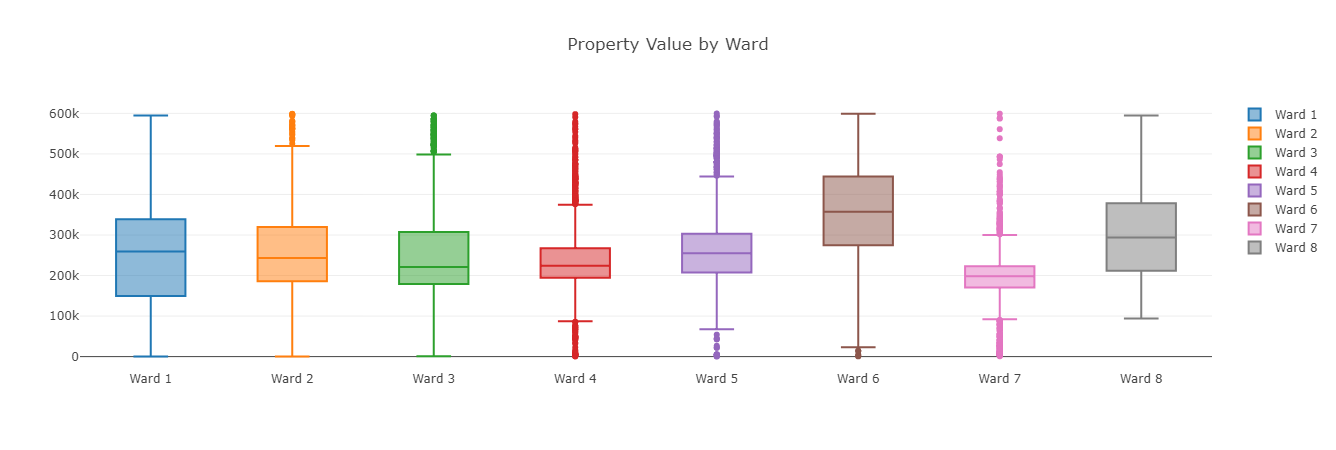

In [11]:
data = [go.Box(y=central_geo.loc[central_geo[ward] == True, "Listed Real Value"], name=ward) for ward in ward_list]
layout = go.Layout(title="Property Value by Ward")
fig = go.Figure(data=data, layout=layout)
iplot(fig)

Some observations based off of these boxplots:
 * There are expensive properties and cheap properties in every single ward, save for 8 which has a higher floor
 * Ward 6 has the highest median value, while Ward 7 has the lowest, as well as seemingly the fewest high-end properties

It is important to remember that the upper end of these distributions have been sawed off, so these boxplots are useful mostly for considering the IQRs.

While the range of the values of the high-end properties are too dispersed to be easily viewed visually, we can get some insights as to where they cluster by looking at counts by Ward.

In [12]:
upper_geo = properties[properties["Listed Real Value"] >= min(upper)]

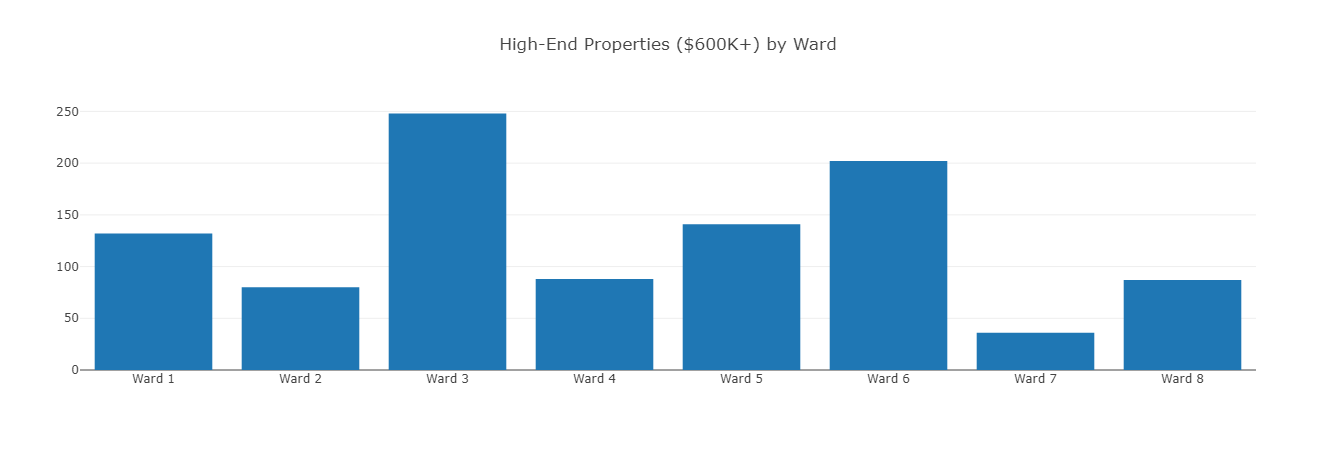

In [16]:
data = [go.Bar(x=ward_list, y=[upper_geo[upper_geo[ward] == True].shape[0] for ward in ward_list])]
layout = go.Layout(title="High-End Properties ($600K+) by Ward")
fig = go.Figure(data=data, layout=layout)
iplot(fig)

The most disproportionally valuable properties are in Ward 3 and Ward 6, while the fewest of these properties are in Ward 7.

Let's summarize what we know about the city wards:
 * Ward 7 has the lowest median property value and the fewest super-properties
 * Ward 6 has the highest median property value and the second most super-properties, making it one of the most desirable areas in Burlington
 * Ward 3 has the highest concentration of super-properties. This is something that it might be interesting to explore further

# Dashboard

To facilitate exploration of this dataset, I developed an interactive dashboard for the generation of interactive maps and tables. A live version of this dashboard may be found at the following address:

[https://burlington-app.herokuapp.com](https://burlington-app.herokuapp.com)

# Report

In [17]:
# Create clean list of last names
last_names = []
with open('../data/last_names.txt', 'r') as f:
    for line in f:
        line = line.replace("\n", "")
        last_names.append(line)
print(len(last_names))
first_names = pd.read_csv('../data/csvs/new-top-firstNames.csv')
first_names = list(first_names.name.str.upper())
first_names_two = pd.read_csv('../data/csvs/ssa_names_db.csv')
first_names = first_names + [x.upper() for x in list(first_names_two['name'])]

3881


In [18]:
first_names = set(first_names)
last_names = set(last_names)
last_names = last_names - first_names
print(len(last_names))

2747


In [19]:
suffixes_etc = set(['TRUST', 'HOUSING', 'JR', 'CITY', 'LIVING', 'AND', 'III', 'II', 'I', 'IV', 'ST', 'LLC', 'SR']
                  + ['TRUSTEE', 'AUTHORITY', 'PARTNERSHIP', 'BROTHERS', 'CHURCH', 'BURLINGTON', 'EST', 'POINT'])
last_names = last_names - suffixes_etc
print(len(last_names))

2733


In [20]:
# Prepare for vectorization
burlington_names = pd.DataFrame({"last_name": list(last_names)})

In [21]:
# Prepare DataFrame for searching
search = pd.merge(principals, properties, how='outer', left_on='property_id', right_on='Parcel ID')

In [22]:
def findWholeWord(word, sentence):
    """Finds a complete word in a sentence.

    Args:
        word (str): Word to be searched for.
        sentence (str): Sentence to be searched.
    
    Returns:
        bool: True if found, False otherwise.
    """
    result = re.compile(r'\b({0})\b'.format(word), flags=re.IGNORECASE).search(sentence)
    if result:
        return True
    else:
        return False

In [23]:
def name_report(name, df=search, institutions=False):
    """Finds property statistics associated with a name.

    Args:
        name (str): Name to be searched for.
        df (DataFrame): DataFrame to be searched.
        institutions (bool): Include major gov institutions only if True.
    
    Returns:
        list: Real estate statistics associated with name.
    """
    df=df
    name=name.upper()
    
    inst_lst = [45152.0, 43409.0, 46484.0, 46891.0, 91718.0]
    
    principal_bool = df.principals.map(lambda x: findWholeWord(name, x))
    owner_bool = df.owner_name.map(lambda x: findWholeWord(name, x))
    
    data = df[
        principal_bool | owner_bool
    ].sort_values(
        ['property_id', 'owner_name', 'principals']
    )

    if institutions == False:
        data = data[data['business_id'].isin(inst_lst) == False]    

    entity_count = len(data['owner_name'].unique())
    
    data = data.drop_duplicates(subset=['property_id'])
    
    prop_count = data.shape[0]
    total_value = data['property_real_value'].sum()
    median_value = data['property_real_value'].median()
    ward_counts = [data[ward].sum() for ward in ward_list]

    return [name, entity_count, prop_count, median_value, total_value] + ward_counts

In [24]:
# Prepare columns for final report
cols = ['last_name', 'entity_count', 'property_count', 'median_value', 'total_value'] + ward_list
cols = [x.lower().replace(" ", "_") for x in cols]

In [25]:
results = burlington_names.last_name.map(name_report)

/home/calre/anaconda2/envs/learn-env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning:

Mean of empty slice



In [26]:
report = pd.DataFrame(list(results))
report.columns = cols

In [27]:
# Replace boolean values and null values
report = report.replace({False: 0, True: 1, np.nan: 0})

In [28]:
report.sort_values('property_count', ascending=False).head(10)

,last_name,entity_count,property_count,median_value,total_value,ward_1,ward_2,ward_3,ward_4,ward_5,ward_6,ward_7,ward_8
695,HANDY,28,59,494700.0,48816900.0,8,3,25,7,8,1,1,5
2359,BROWN,33,37,240900.0,10334900.0,3,2,7,1,9,5,10,0
872,DIEMER,5,31,126900.0,6003300.0,19,12,0,0,0,0,0,0
616,MCGOWAN,4,31,319900.0,10362600.0,0,16,14,1,0,0,0,0
1776,EASTMAN,7,29,95000.0,6025900.0,0,0,1,27,1,0,0,0
1382,BISSONETTE,12,28,260350.0,10260400.0,1,6,14,4,1,0,1,1
736,GREEN,25,26,224650.0,14611100.0,2,1,5,7,1,3,3,4
2113,BURNS,13,23,293200.0,7626700.0,5,7,2,2,2,3,1,1
362,LECLAIR,16,23,409800.0,9331600.0,0,3,4,1,0,9,4,2
1723,BOARDMAN,10,20,314300.0,13107900.0,0,0,0,3,1,16,0,0


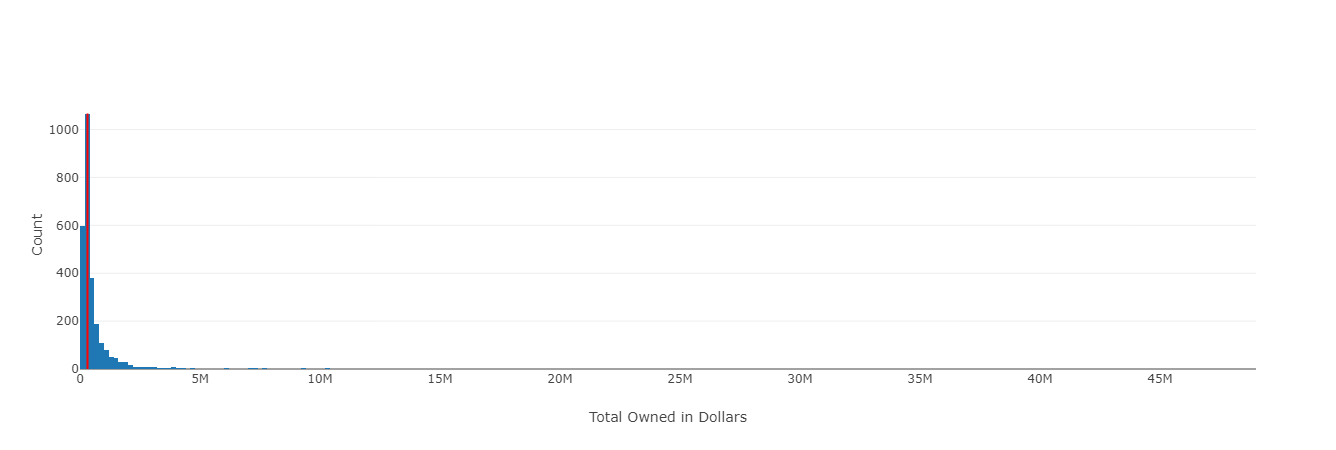

In [29]:
plotly_hist(report['total_value'], "Total Owned in Dollars", "Count", 1067)

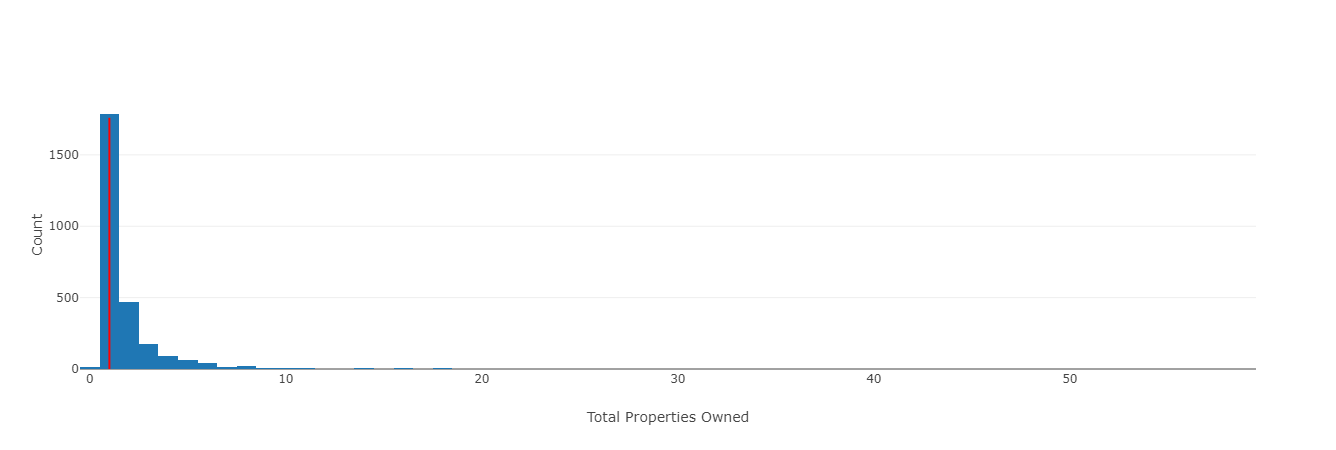

In [30]:
plotly_hist(report['property_count'], "Total Properties Owned", "Count", 1760)

In [31]:
wards = list(report.columns[-8:])

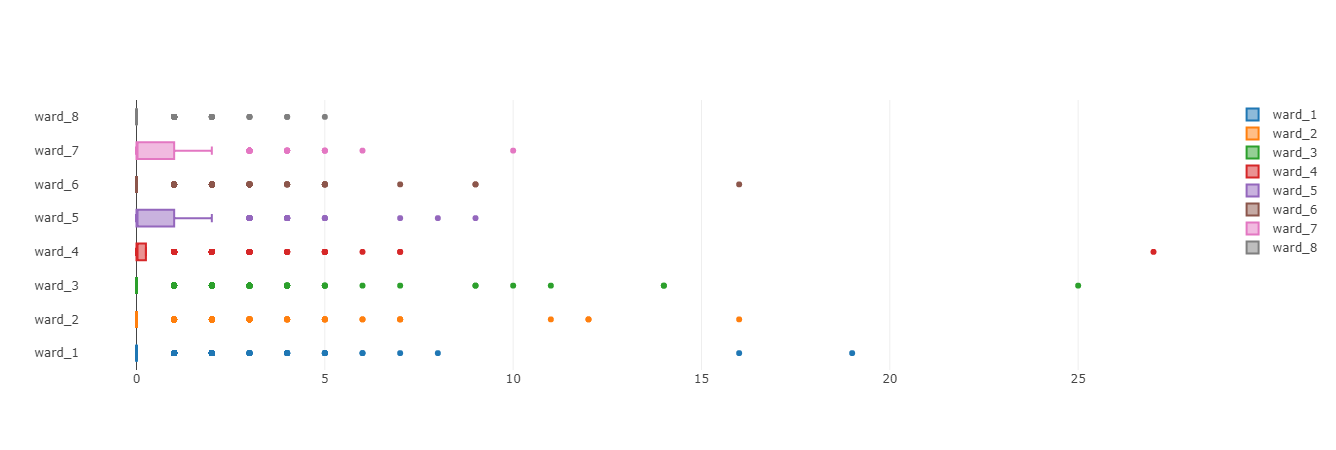

In [32]:
data = [go.Box(x=report[ward], name=ward) for ward in wards]
iplot(data)

# Most Properties in City

In [33]:
super_owners = report[report['property_count'] >= 10].sort_values('property_count', ascending=False)

In [34]:
super_owners.head(20)

,last_name,entity_count,property_count,median_value,total_value,ward_1,ward_2,ward_3,ward_4,ward_5,ward_6,ward_7,ward_8
695,HANDY,28,59,494700.0,48816900.0,8,3,25,7,8,1,1,5
2359,BROWN,33,37,240900.0,10334900.0,3,2,7,1,9,5,10,0
616,MCGOWAN,4,31,319900.0,10362600.0,0,16,14,1,0,0,0,0
872,DIEMER,5,31,126900.0,6003300.0,19,12,0,0,0,0,0,0
1776,EASTMAN,7,29,95000.0,6025900.0,0,0,1,27,1,0,0,0
1382,BISSONETTE,12,28,260350.0,10260400.0,1,6,14,4,1,0,1,1
736,GREEN,25,26,224650.0,14611100.0,2,1,5,7,1,3,3,4
362,LECLAIR,16,23,409800.0,9331600.0,0,3,4,1,0,9,4,2
2113,BURNS,13,23,293200.0,7626700.0,5,7,2,2,2,3,1,1
2558,POMERLEAU,13,20,593950.0,26327400.0,0,0,9,5,3,3,0,0


In [39]:
super_owners = super_owners[super_owners.last_name.isin(['BROWN', 'GREEN', 'WHITE']) == False]

In [40]:
super_owners['last_name'].str.title()[:15]

695          Handy
616        Mcgowan
872         Diemer
1776       Eastman
1382    Bissonette
362        Leclair
2113         Burns
2558     Pomerleau
1723      Boardman
2023    Offenhartz
2095       Nichols
2135       Khamnei
2342         Walsh
598         Donath
1803       Mcgrath
Name: last_name, dtype: object

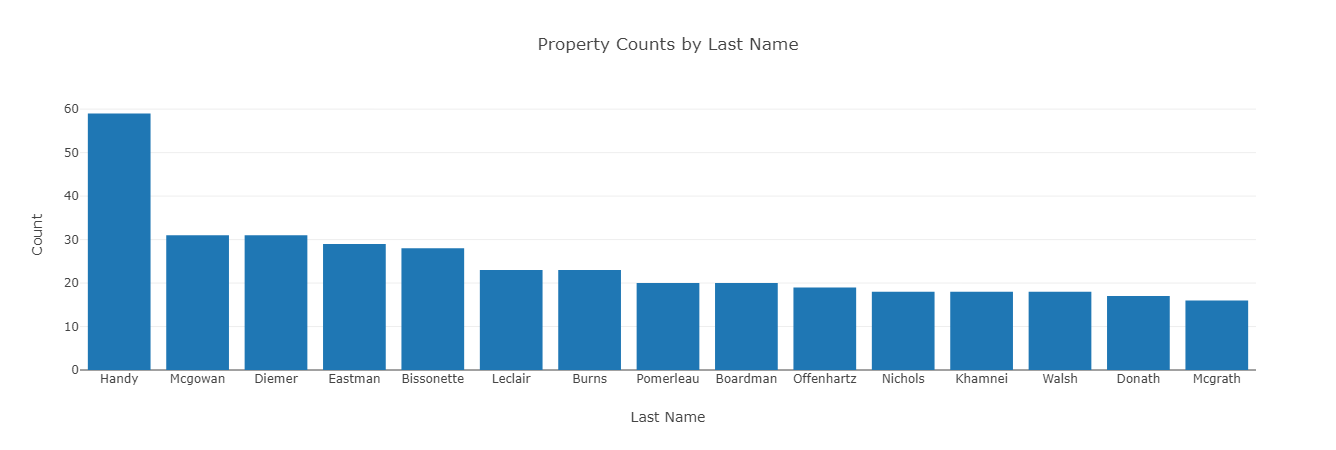

In [41]:
trace = go.Bar(y=super_owners['property_count'][0:15], x=super_owners['last_name'].str.title()[:15])
data = [trace]
layout = go.Layout(title="Property Counts by Last Name", xaxis=dict(title="Last Name"), yaxis=dict(title="Count"))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

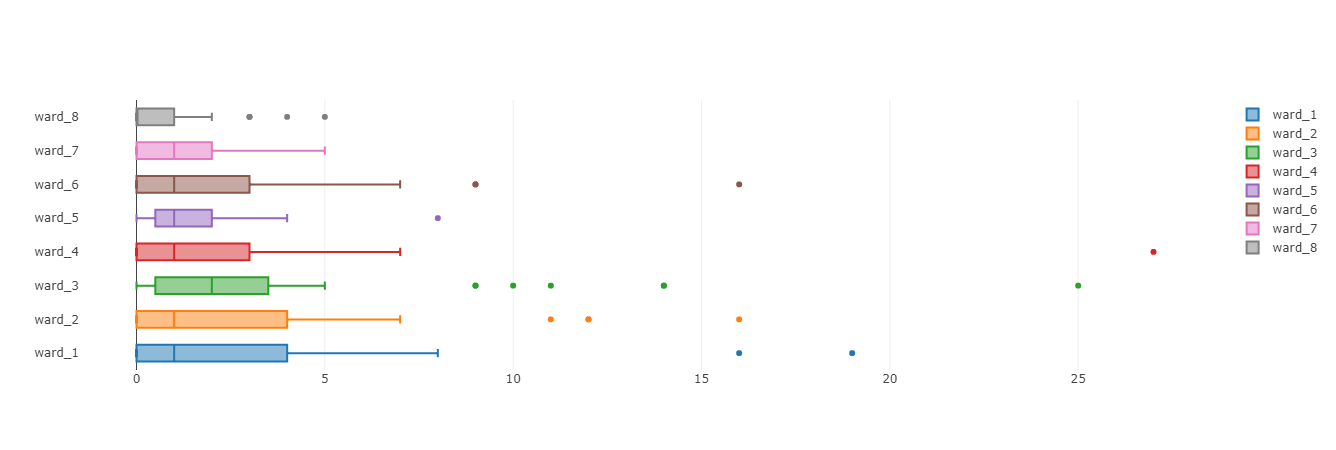

In [42]:
data = [go.Box(x=super_owners[ward], name=ward) for ward in wards]
layout = go.Layout(title="")
iplot(data)

In [43]:
# Proportion of total property owned by super-owners
sum(super_owners['property_count']) / properties.shape[0]

0.06776844243375496

# Most Properties in Each Ward

In [44]:
def ward_top_three(df):
    df = df[df.last_name.isin(['BROWN', 'GREEN', 'WHITE']) == False]
    top_list = []
    for ward in wards:
        top_three = df.sort_values(by=ward, ascending=False).head(3).copy()
        top_three['top_three_in'] = ward
        top_list.append(top_three)
    return pd.concat(top_list)[['top_three_in', 'last_name', 'entity_count', 'property_count', 'median_value',
       'total_value', 'ward_1', 'ward_2', 'ward_3', 'ward_4', 'ward_5',
       'ward_6', 'ward_7', 'ward_8']]

In [45]:
ward_top_three = ward_top_three(report)

In [46]:
ward_top_three

,top_three_in,last_name,entity_count,property_count,median_value,total_value,ward_1,ward_2,ward_3,ward_4,ward_5,ward_6,ward_7,ward_8
872,ward_1,DIEMER,5,31,126900.0,6003300.0,19,12,0,0,0,0,0,0
1527,ward_1,KAANTA,5,16,126750.0,2047100.0,16,0,0,0,0,0,0,0
695,ward_1,HANDY,28,59,494700.0,48816900.0,8,3,25,7,8,1,1,5
616,ward_2,MCGOWAN,4,31,319900.0,10362600.0,0,16,14,1,0,0,0,0
1641,ward_2,ATWOOD,5,13,328300.0,4829600.0,0,12,0,1,0,0,0,0
872,ward_2,DIEMER,5,31,126900.0,6003300.0,19,12,0,0,0,0,0,0
695,ward_3,HANDY,28,59,494700.0,48816900.0,8,3,25,7,8,1,1,5
616,ward_3,MCGOWAN,4,31,319900.0,10362600.0,0,16,14,1,0,0,0,0
1382,ward_3,BISSONETTE,12,28,260350.0,10260400.0,1,6,14,4,1,0,1,1
1776,ward_4,EASTMAN,7,29,95000.0,6025900.0,0,0,1,27,1,0,0,0


This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]  [ (1,4) x4,y4 ]
[ (2,1) x5,y5 ]  [ (2,2) x6,y6 ]  [ (2,3) x7,y7 ]  [ (2,4) x8,y8 ]



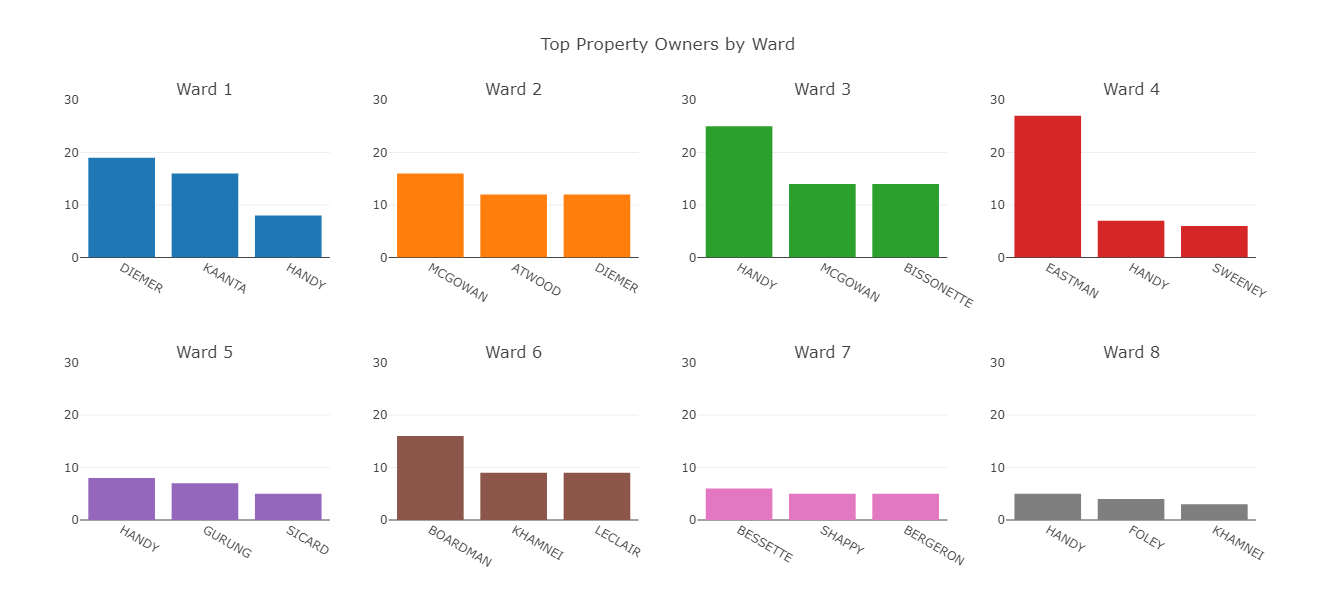

In [47]:
from plotly import tools

def get_ward_bar(df, ward):
    df = df[df['top_three_in'] == ward]
    x = list(df.last_name)
    y = list(df[ward])
    return (x, y)

traces = []

for i, ward in enumerate(wards):
    x, y = get_ward_bar(ward_top_three, ward)
    trace = go.Bar(x=x, y=y, name=ward_list[i])
    traces.append(trace)

fig = tools.make_subplots(rows=2, cols=4, subplot_titles=ward_list)

for i, trace in enumerate(traces):
    a = (i // 4) + 1
    b = (i % 4) + 1
    fig.append_trace(trace, a, b)
    
fig['layout'].update(height=600, width=900, yaxis=dict(range=[0,30]), showlegend=False, title='Top Property Owners by Ward')
for i in range(1,9):
    fig['layout']['yaxis' + str(i)].update(range=[0,30])
    fig['layout']['xaxis' + str(i)].update(tickangle=30)
    
iplot(fig)

In [48]:
ward_top_three.last_name.value_counts()

HANDY         5
MCGOWAN       2
DIEMER        2
KHAMNEI       2
SWEENEY       1
BERGERON      1
BESSETTE      1
BISSONETTE    1
GURUNG        1
BOARDMAN      1
LECLAIR       1
ATWOOD        1
FOLEY         1
SICARD        1
EASTMAN       1
KAANTA        1
SHAPPY        1
Name: last_name, dtype: int64

# Top by Total Value of Properties

In [52]:
over_two_million = report[report['total_value'] > 2000000]
over_two_million = over_two_million[over_two_million.last_name.isin(['BROWN', 'GREEN', 'WHITE']) == False]

In [53]:
over_two_million = over_two_million.sort_values('total_value', ascending=False)
over_two_million.head(15)

,last_name,entity_count,property_count,median_value,total_value,ward_1,ward_2,ward_3,ward_4,ward_5,ward_6,ward_7,ward_8
695,HANDY,28,59,494700.0,48816900.0,8,3,25,7,8,1,1,5
2558,POMERLEAU,13,20,593950.0,26327400.0,0,0,9,5,3,3,0,0
177,HOEKSTRA,8,10,395850.0,23164600.0,0,5,5,0,0,0,0,0
598,DONATH,9,17,657200.0,14080900.0,5,1,0,3,1,5,0,2
2044,CANNING,3,3,450800.0,13422300.0,0,0,1,0,2,0,0,0
1723,BOARDMAN,10,20,314300.0,13107900.0,0,0,0,3,1,16,0,0
2095,NICHOLS,10,18,405000.0,12779200.0,1,1,11,1,2,1,1,0
45,DESLAURIERS,1,1,12712200.0,12712200.0,0,0,1,0,0,0,0,0
1451,HAUKE,1,5,745200.0,10946000.0,0,0,0,2,0,0,2,0
2637,UNSWORTH,4,6,808800.0,10937100.0,0,0,0,1,3,2,0,0


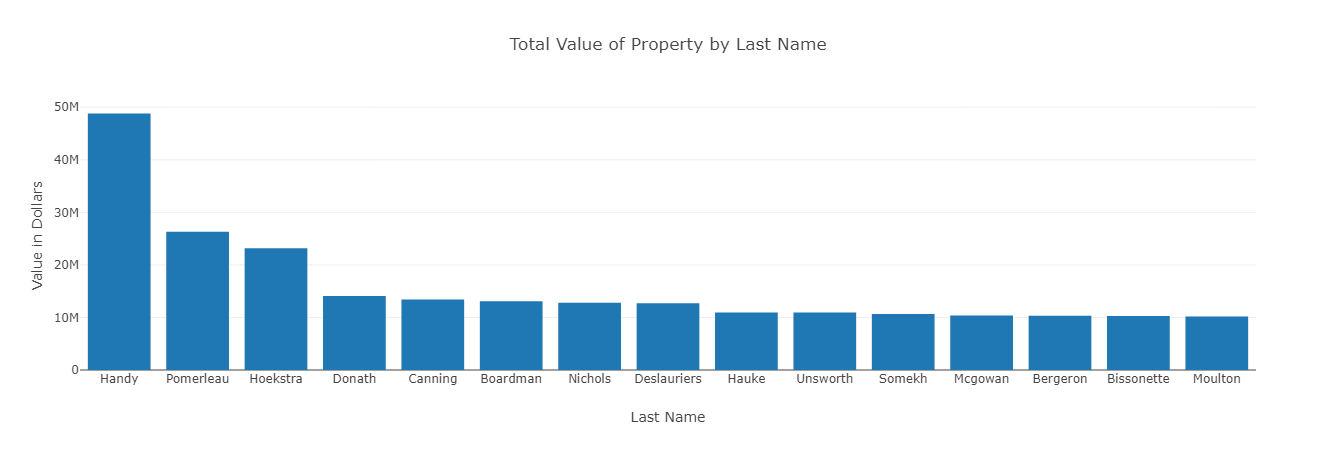

In [54]:
trace = go.Bar(y=over_two_million['total_value'][0:15], x=over_two_million['last_name'].str.title()[:15])
data = [trace]
layout = go.Layout(title="Total Value of Property by Last Name", xaxis=dict(title="Last Name"), yaxis=dict(title="Value in Dollars"))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

# Top by Number of Entities

In [55]:
report.sort_values('entity_count', ascending=False).head(20)

,last_name,entity_count,property_count,median_value,total_value,ward_1,ward_2,ward_3,ward_4,ward_5,ward_6,ward_7,ward_8
2359,BROWN,33,37,240900.0,10334900.0,3,2,7,1,9,5,10,0
695,HANDY,28,59,494700.0,48816900.0,8,3,25,7,8,1,1,5
736,GREEN,25,26,224650.0,14611100.0,2,1,5,7,1,3,3,4
672,WHITE,17,18,271350.0,7008500.0,0,2,3,5,2,2,2,1
362,LECLAIR,16,23,409800.0,9331600.0,0,3,4,1,0,9,4,2
2342,WALSH,16,18,232250.0,5419900.0,0,3,2,4,2,5,2,0
1803,MCGRATH,15,16,203750.0,3450600.0,1,1,1,4,2,5,2,0
282,HILL,14,16,246400.0,6239900.0,4,1,5,0,1,4,1,0
1458,BOVE,14,14,286150.0,7783100.0,6,0,3,1,2,0,1,1
2168,HALL,13,15,310800.0,6018000.0,5,0,0,1,2,5,1,1


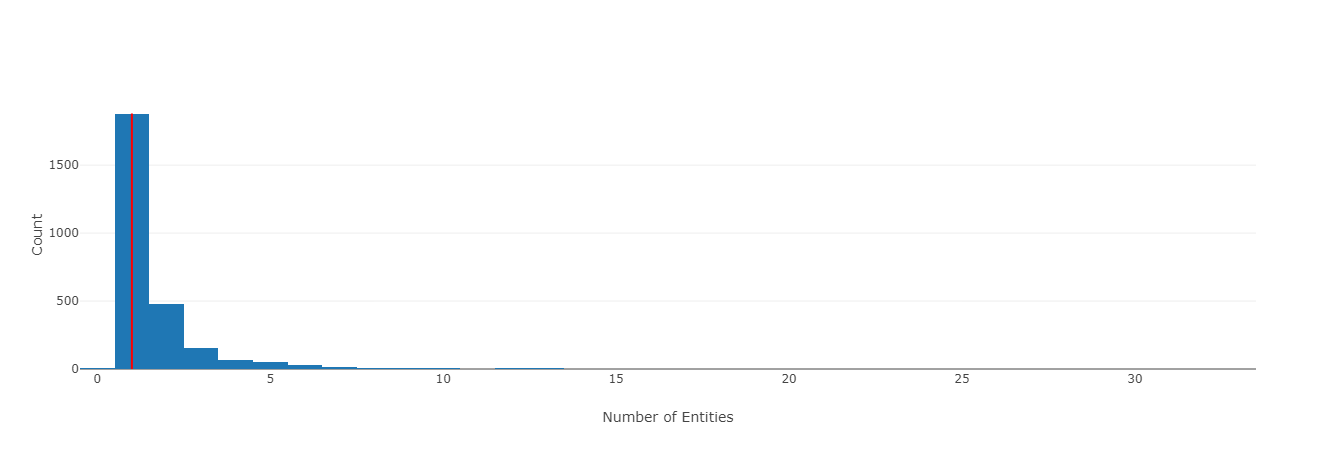

In [56]:
plotly_hist(report['entity_count'], "Number of Entities", "Count", 1880)

# Conclusion

* The Handy family is the dominant real estate power in Burlington, VT, owning both the most numerous and most valuable properties of any independent non-institutional property owner in VT.
* Several super-owners of real estate are especially dominant in a single chosen city ward. Specifically:
    * Ward 3: Handy with 25 properties
    * Ward 4: Eastman with 27 properties
    * Ward 6: Boardman with 16 properties
* Diemer nears the top of the super-owner list by the numbers, but many of their units are located inside of a single building. This is not the case for other super-owners.
* While Handy leads the pack in terms of total dollars worth owned, Pomerleau and Hoekstra are also major players when it comes to expensive real estate
* Eastman is a huge outlier when it comes to owning many inexpensive properties. This appears to be because of many purchases of empty lots for development on Appletree Point Road. I can only surmise he has big plans for the area.
* Among super-owners, Pomerleau, Donath, and Handy are notable for focusing on higher-end properties, while Bissonette largely focuses on more modest opportunities.
* Walsh and McGrath also own many less expensive homes, but it is unclear that this is a coordinated buying plan. They may just be large families of single homeowners.
* For similar reasons, Brown, Green, White et al should be excluded from analysis except for by regional experts